In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.preprocessing import normalize
from scipy import signal
import skimage
import tifffile as tiff
import os
import math
import json
from skimage.measure import label
from skimage.measure import regionprops
from com import *
import csv
from tqdm.notebook import tqdm
from skeleton import *
kwargs = {"10":10, "100":100}
print(**kwargs)

In [1]:
csvpath = "/home/isis0517/Documents/data/20210115/0115-03.csv"
imgspath = "/media/isis0517/QVO2/0115/03"
savepath = "/home/isis0517/Documents/data/20210115"
    

flist = os.listdir(imgspath)
tiflist = []
for filename in flist:
    if os.path.isdir(filename):
        continue
    if filename.split(".")[-1] == "npy" :
        tiflist.append(filename)

print('There is a total of ',len(tiflist), 'images')
frame_num = len(tiflist)
#for srt in os.listdir(path):
#flist.append(srt.split('_'))

#排序路徑
tiflist.sort(key = lambda x: int(x.split("_")[-1].split(".")[0]))

#變成絕對路徑
flist = []
for filename in tiflist:
    flist.append(os.path.join(imgspath, filename))

NameError: name 'os' is not defined

# Generate the background

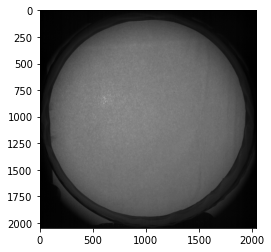

In [9]:
nbckgnd = 500
tnum = np.random.randint(len(flist),size=nbckgnd)
tlist=[]
for s in tnum:
    tlist.append(flist[s])

img_shape = np.load(flist[0]).shape[0:2]
total = np.zeros(img_shape)
for file in tlist:
    b = np.load(file)
    img = cv2.cvtColor(b, cv2.COLOR_BayerBG2GRAY)
    #img = cv2.blur(img)
    total = total + img
background = (total/nbckgnd).astype('uint8')
cbackground = background
shape = img_shape
plt.imshow(background, plt.cm.gray)

In [10]:
img =np.load(flist[0])
size = 120 #cv2.VideoWriter_fourcc(*'MPEG')
video = cv2.VideoWriter(os.path.join(savepath, "path_video03.avi"), cv2.VideoWriter_fourcc(*'MPEG'),
                        40, (size*2+1, size*2+1), isColor=False)

traj = []
cross = []
with open(csvpath, newline='') as csvfile:

  # 讀取 CSV 檔案內容
    rows = csv.reader(csvfile, delimiter=';')

  # 以迴圈輸出每一列
    for s,row in enumerate(tqdm(rows)):
        if s > 0 :
            try:
                pos = (int(row[2]), int(row[1]))
            except Exception as e:
                print(e)
                break
            cross.append(row[3]=='1')
            traj.append(pos)
            img = np.load(flist[s-1])
            img = cv2.cvtColor(img, cv2.COLOR_BayerBG2GRAY)
            img = cv2.absdiff(img, background)
            img = np.where(img>15, 255, 0).astype('uint8')
            img = cutting_img(img, pos, 120)
            video.write(img)
    video.release()
        

invalid literal for int() with base 10: '205.69492408293127'



In [14]:
img =np.load(flist[0])
shape = img.shape[0:2]

rposes = []
for pos in traj:
    rposes.append((pos[0]/shape[0], pos[1]/shape[1]))
    
np.save("0115-03_trj.npy", rposes
       )

# 根據 path 切出新的影像
預先讀入切割後的圖片

In [1]:
traj = []
cross = []
imgs = []

id_imgpath = os.path.join(savepath,"03_id")
try:
    os.mkdir(id_imgpath)
except Exception as e:
    print(e)

with open(csvpath, newline='') as csvfile:

  # 讀取 CSV 檔案內容
    rows = csv.reader(csvfile, delimiter=';')

  # 以迴圈輸出每一列
    for s,row in enumerate(tqdm(rows)):
        if s > 0 :
            try:
                pos = (int(float(row[2])), int(float(row[1])))
            except Exception as e:
                print(e)
                break
            cross.append(row[3]=='1')
            traj.append(pos)
            img = np.load(flist[s-1])
            img = cv2.cvtColor(img, cv2.COLOR_BayerBG2GRAY)
            img = cv2.absdiff(img, background)
            img = np.where(img>15, 255, 0).astype('uint8')
            img = cutting_img(img, pos, 120)
            imgs.append(img)
            np.save(os.path.join(id_imgpath, f"frame_{s-1:05d}.npy"), img)
        

NameError: name 'os' is not defined

# 轉正圖片
    同時把position更新，以利於後面計算速度

In [33]:
poses = []
ori_sks = []
rot_imgs = []
for s, img in enumerate(tqdm(imgs)):
    img = cutting_img(img, (120,120), 100)
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        continue
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    
    #等邀三角只要知道第三邊長c就可以算出角度，但如要知道旋轉的方向則須判別兩向量正負號
    #sin(angle) = a[1]b[0]-a[0]b[1]
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sk)
    ori_sks.append(sk)
    M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (201,201))
    rot_imgs.append(rotated)
    poses.append(traj[s])

# 增加數據量(相反)

左右相反
!注意! 不增加poses長度

In [19]:
for s, img in enumerate(tqdm(imgs)):
    img = cutting_img(img, (120,120), 100)
    img = np.flip(img, axis=1)
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        continue
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    
    #等邀三角只要知道第三邊長c就可以算出角度，但如要知道旋轉的方向則須判別兩向量正負號
    #sin(angle) = a[1]b[0]-a[0]b[1]
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sks)
    ori_sks.append(sk)
    M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (201,201))
    rot_imgs.append(rotated)

In [20]:
for s, img in enumerate(tqdm(imgs)):
    img = cutting_img(img, (120,120), 100)
    img = np.flip(img, axis=0)
    try:
        sk = NT_skeleton(img)
    except Exception as e:
        print(s, e)
        continue
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    
    #等邀三角只要知道第三邊長c就可以算出角度，但如要知道旋轉的方向則須判別兩向量正負號
    #sin(angle) = a[1]b[0]-a[0]b[1]
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]>0:
        angle = -angle
    if angle != angle:
        print("算錯啦")
        print(sks)
    ori_sks.append(sk)
    M = cv2.getRotationMatrix2D((100, 100), 180+angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (201,201))
    rot_imgs.append(rotated)

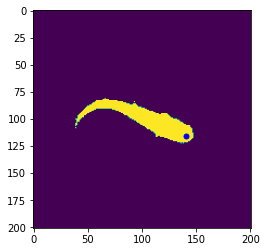

NameError: name 'sks' is not defined

In [24]:
s = 9825*2+2
img = imgs[s]
img = cutting_img(img, (120,120), 100)

plt.imshow(img)
sk = np.flip(NT_skeleton(img), axis=1)
plt.plot(*sk[0].T, 'b.', ms=10)
plt.show()
print(len(sks), len(rot_imgs))

# apply eigenfish

In [34]:
def an2vec(an, r):
    x = np.cos(an)
    y = np.sin(an)
    return r*np.array([x,y])

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

def an2ori(an_sk, vec=np.array([0,1]), intens=1):
    test_sk = [vec]
    for i in range(len(an_sk)):
        vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
        test_sk.append(test_sk[-1]+vec)

    return np.array(test_sk)

vec_sks = []
for s, sk in enumerate(ori_sks):
    vec = []
    for i in range(len(sk)-1):
        vec.append(sk[i+1]-sk[i])
    if len(sk)<10:
        plt.imshow(imgs[s])
        print(s, NT_skeleton(imgs[s]))
        plt.show()
        
    vec_sks.append(vec)
han_sks=[]
n=0
for s, vec_sk in enumerate(vec_sks):
    heading = vec_sk[0]
    han_sk=[]
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(s, vec_sk)
        err = a-np.dot(b, get_rot_M(angle))
        if np.linalg.norm(err) > 0.1:
            #print("turning", a, np.dot(b, get_rot_M(-angle)))
            angle=-angle
        han_sk.append(angle)
    n+=1
    han_sks.append(han_sk)
print(len(han_sks))
han_sks = np.array(han_sks[0:60000])

23423


[0.8383077  0.1076796  0.02746512] 0.9734524262843809


array([-0.70638786, -0.09803961, -0.26151121])

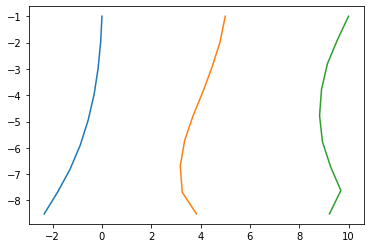

In [35]:

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(han_sks)
pc1 = pca.components_[0]
u = np.array([0,-1])
n=0
for pcs in pca.components_:
    sk = [u]
    pcs = pcs*1
    for an in pcs:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+n*5,sk[:,1])
    n+=1
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

pca_sks = pca.transform(han_sks)

pca_sks[s]

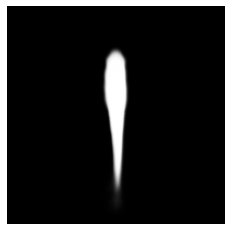

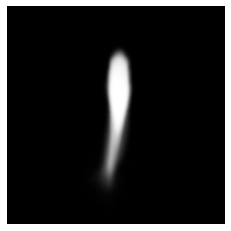

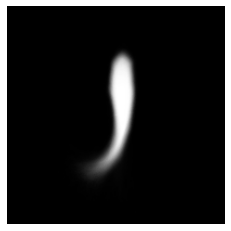

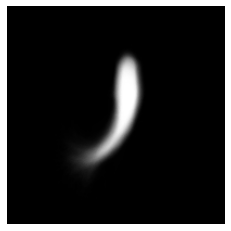

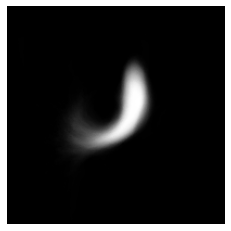

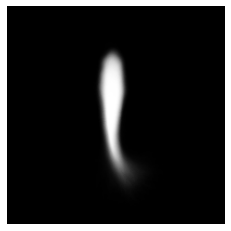

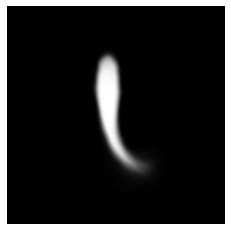

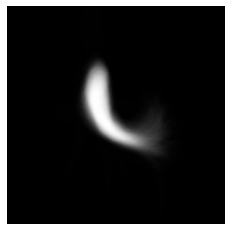

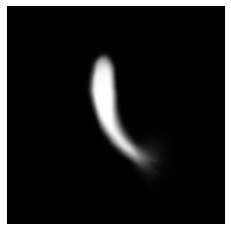

(9, 40401)

In [36]:

init_cen = []
cenlist = os.listdir(os.path.join(savepath, "init_cen"))
cenlist.sort()
for file in cenlist:
    img = cv2.imread(os.path.join(savepath, "init_cen", file), cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, plt.cm.gray)
    plt.axis('off')
    plt.show()
    init_cen.append(img.flatten()>200)
    
init_cen = np.array(init_cen)
init_cen.shape

In [37]:
from sklearn.cluster import KMeans

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, algorithm="elkan", init="k-means++", tol=1e-10, n_init=20)
kmeans.fit(pca_sks)
labels = kmeans.predict(pca_sks)
centers = kmeans.cluster_centers_

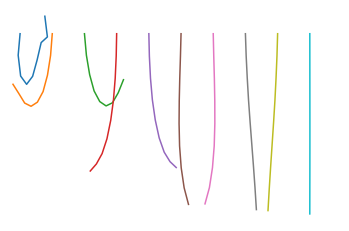

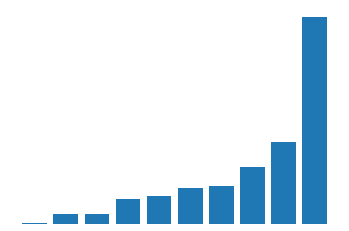

In [38]:

nums, bins = np.histogram(labels, bins=np.arange(n_clusters+1)-0.5)
ords = np.argsort(nums)

for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas, pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1
plt.axis('off')
plt.xlim([-2, n_clusters*5])
plt.show()
plt.bar(bins[:-1], nums[ords])
plt.axis('off')
plt.show()

0


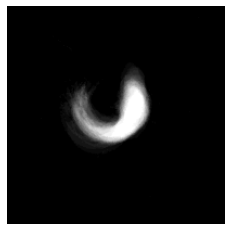

1


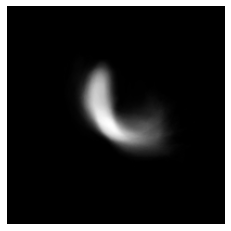

2


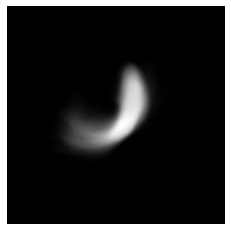

3


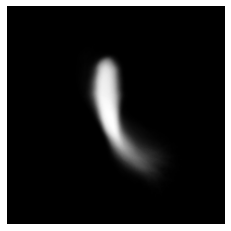

4


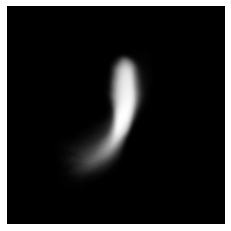

5


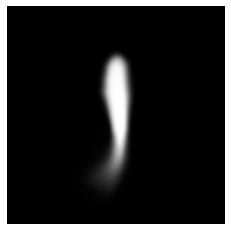

6


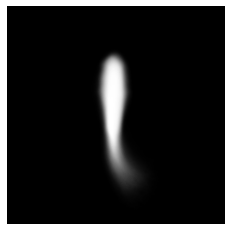

7


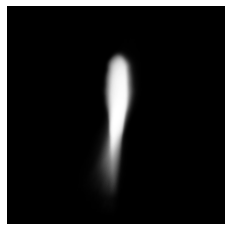

8


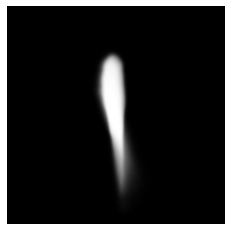

9


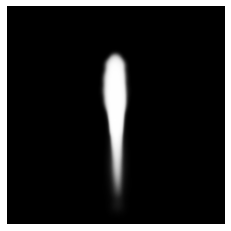

In [39]:
cen_imgs = np.zeros((n_clusters, 201, 201), dtype='int')
for s, label in enumerate(labels[:len(rot_imgs)]):
    cen_imgs[label] += rot_imgs[s]
for s, img in enumerate(cen_imgs[ords]):
    cen_imgs[s] = (img/nums[ords[s]]).astype('uint8')
    print(s)
    #cv2.imwrite(os.path.join(savepath,f"centers_{s}.png"), img*255)
    plt.imshow(cen_imgs[s], plt.cm.gray)
    plt.axis('off')
    plt.show()


In [40]:
print(len(rot_imgs), len(labels), len(poses), len(ori_sks))

23423 23423 23423 23423


# genrate the vidoe which replace by centers

In [41]:

video.release()
#cv2.VideoWriter_fourcc(*'MPEG')
video = cv2.VideoWriter(os.path.join(savepath, "cen_video.avi"), cv2.VideoWriter_fourcc(*'MPEG'),
                        40, (201, 201), isColor=False)
for label in labels[:len(poses)]:
    video.write(cen_imgs[label].astype('uint8'))
video.release()

# encode the speed(distance) and angle
注意index 從 1:-1

<ipython-input-42-0de887badb84>:11: RuntimeWarning: invalid value encountered in true_divide
  a = v/np.linalg.norm(v, ord=2)


array([-3.53429174, -2.74889357, -1.96349541, -1.17809725, -0.39269908,
        0.39269908,  1.17809725,  1.96349541,  2.74889357])

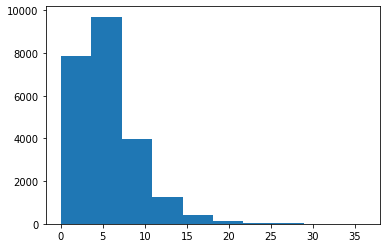

In [42]:
h_an = []
v_an = []
distes = []
poses = np.array(poses)

s=1
for pos in tqdm(poses[1:-1]):
    v = (poses[s+1]-poses[s])
    distes.append(np.linalg.norm(v))
    
    a = v/np.linalg.norm(v, ord=2)
    b = np.array([1,0])
    
    #等邀三角只要知道第三邊長c就可以算出角度，但如要知道旋轉的方向則須判別兩向量正負號
    #sin(angle) = a[1]b[0]-a[0]b[1]
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]<0:# counterclockwise is positive
        angle = -angle
    v_an.append(angle)
    
    sk = ori_sks[s]
    v1 = sk[0]-sk[2]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    
    #等邀三角只要知道第三邊長c就可以算出角度，但如要知道旋轉的方向則須判別兩向量正負號
    #sin(angle) = a[1]b[0]-a[0]b[1]
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    if a[1]<0:# counterclockwise is positive
        angle = -angle
    h_an.append(angle)
    s+=1
plt.hist(distes)
dis_bins = [0,2,5,8,40]
an_bins = np.array([-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2, 3/4, 1])-1/8
an_bins = an_bins*np.pi
an_bins



doing embedding

In [43]:
codes = []
code_len = 4*8*8*n_clusters
mapping = np.arange(code_len).reshape(4,8,8,n_clusters)
for s, pos in enumerate(tqdm(poses[1:-1])):
    dis_code = 0
    for bins in dis_bins[1:]:
        if distes[s] < bins:
            break
        dis_code+=1
    if dis_code >= 4:
        print("out of range : ", distes[s])
    
    an_code = 0
    for bins in an_bins[1:]:
        if h_an[s]<bins:
            break
        an_code += 1
    if an_code == 8:
        an_code=0
    if an_code >= 8:
        print("out of range : ", h_an[s])
        
    v_an_code = 0
    for bins in an_bins[1:]:
        if v_an[s]<bins:
            break
        v_an_code += 1
    if v_an_code == 8:
        v_an_code=0
    if v_an_code >= 8:
        print("out of range : ", v_an[s])
        
    codes.append(mapping[dis_code, an_code, v_an_code, labels[s]])

invers_map = []
for d in range(4):
    for h_a in range(8):
        for v_a in range(8):
            for l in range(n_clusters):
                invers_map.append((d, h_a, v_a, l))
invers_map = np.array(invers_map)

c2dis = [1,3,5,13]
c2an = np.array([-1, -3/4, -1/2, -1/4, 0, 1/4, 1/2, 3/4, 1])*np.pi

In [268]:
len(set(codes))
np.save("fish_mur2.npy", codes)

In [285]:
new_seq = np.load("fish_murme2.npy")
print(len(new_seq))

12001


In [44]:
video.release()
#cv2.VideoWriter_fourcc(*'MPEG')
video = cv2.VideoWriter(os.path.join(savepath, "real_video.avi"), 0 #cv2.VideoWriter_fourcc(*'MPEG')
                        , 40, (2000, 2000), isColor=False)
pos = np.array([1000,1000])
back = np.zeros((2000,2000), dtype='uint8')
u = np.array([0,-1])
for v, h_an, v_an ,label in tqdm(invers_map[codes]):
    M = cv2.getRotationMatrix2D((100, 100), -c2an[h_an]/(np.pi)*180, 1)
    dis = np.dot(get_rot_M(c2an[v_an]), u)
    dis = dis*c2dis[v]
    rotated = cv2.warpAffine(cen_imgs[label].astype('uint8'), M, (201,201))
    #print(c2dis[v], c2an[v_an]/np.pi*180, dis.astype(np.int), pos)
    video.write(glue_img(rotated, (pos[1],pos[0]), back))
    pos = pos+dis.astype(np.int)
    
    if pos[0]>2000:
        pos[0] = 0
    if pos[0]<0:
        pos[0]=2000
    if pos[1]>2000:
        pos[1] = 0
    if pos[1]<0:
        pos[1]=2000
video.release()

(-0.5, 200.5, 200.5, -0.5)

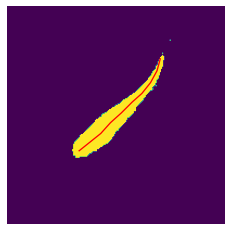

In [45]:
s = 17
plt.imshow(cutting_img(imgs[s], (120,120), 100))
plt.plot(*np.flip(ori_sks[s], axis=1).T, lw=1.3, color='r')
plt.axis('off')

In [46]:
set(codes)

{0,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 10,
 12,
 13,
 14,
 16,
 17,
 18,
 21,
 22,
 23,
 24,
 25,
 27,
 28,
 30,
 31,
 32,
 34,
 35,
 37,
 38,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 50,
 52,
 54,
 55,
 56,
 57,
 58,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 70,
 71,
 72,
 73,
 74,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 90,
 91,
 92,
 93,
 94,
 96,
 97,
 98,
 100,
 101,
 102,
 103,
 104,
 106,
 107,
 108,
 112,
 113,
 115,
 116,
 120,
 121,
 122,
 123,
 126,
 127,
 128,
 130,
 132,
 134,
 135,
 137,
 138,
 140,
 141,
 142,
 143,
 144,
 145,
 147,
 148,
 150,
 151,
 154,
 155,
 156,
 157,
 158,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 175,
 176,
 177,
 178,
 180,
 181,
 182,
 183,
 185,
 186,
 187,
 188,
 190,
 192,
 193,
 196,
 197,
 198,
 200,
 201,
 202,
 203,
 205,
 206,
 207,
 208,
 211,
 212,
 213,
 214,
 216,
 217,
 218,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 230,
 234,
 235,
 237,
 238,
 240,
 241,
 

In [47]:
## calculate the entropy of different length of alphbet --> the estimated entropy

def En_of_lens(series:list, **kwargs):
    L = len(series)
    max_len = kwargs.pop('max_len', np.ceil(np.log2(L)))
    
    ser2set, map_series, counts = np.unique(series ,return_inverse=True, return_counts=True, axis=0)
    ens = [np.log2(L)-np.sum([su/L*np.log2(su) for su in counts])]
    
    for n in range(1, max_len):
        
        #print(len(ser2set), map_series)
        temp = np.concatenate((np.stack((map_series[:-n], series[n:]), axis=-1),
                               np.stack((map_series[-n:], series[:n]), axis=-1)), axis=0)

        ser2set, map_series, counts = np.unique(temp ,return_inverse=True, return_counts=True, axis=0)
        ens.append((np.log2(L)-np.sum([su/L*np.log2(su) for su in counts]))/(n+1))
    return ens

1013561


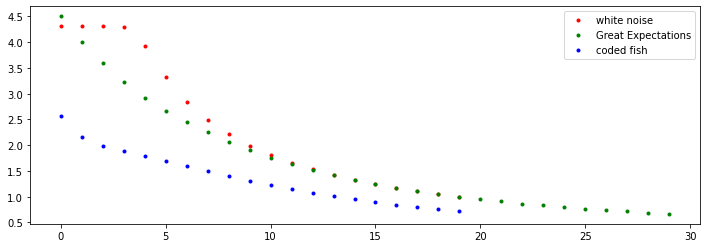

In [53]:
text_as_int = np.load("text_as_int.npy")
test = np.random.randint(20, size=int(1e6))
plt.figure(figsize=(12,4))
plt.plot(En_of_lens(test, max_len=20), 'r.', label="white noise")
plt.plot(En_of_lens(text_as_int, max_len=30), 'g.', label="Great Expectations")
plt.plot(En_of_lens(labels, max_len=20), 'b.', label="coded fish")
plt.legend()
print(len(text_as_int))

In [383]:

ser2set = {value: s for s, value in enumerate(set(codes))}
map_series = list(map(lambda x: ser2set[x] , codes))

In [425]:
temp = np.concatenate((np.stack((map_series[0:-1], map_series[1:]), axis=-1), np.stack((map_series[-1:], map_series[:1]), axis=-1)), axis=0)

In [427]:
un, invers, counts = np.unique(temp ,return_inverse=True, return_counts=True, axis=0)
print(invers[:10], map_series[:10], un[invers[0]])

[5905 3099 2996 2959 3102 3098 2959 3098 2959 3102] [1020, 639, 636, 631, 639, 639, 631, 639, 631, 639] [1020  639]


In [397]:
temp = np.stack()

'1.19.5'